# 宝可梦数据集实战

## 迁移学习


迁移学习(Transfer Learning)是机器学习的一个研究方向，主要研究如何将任务 A 上面
学习到的知识迁移到任务 B 上，以提高在任务 B 上的泛化性能。例如任务 A 为猫狗分类
问题，需要训练一个分类器能够较好的分辨猫和狗的样本图片，任务 B 为牛羊分类问题。
可以发现，任务 A 和任务 B 存在大量的共享知识，比如这些动物都可以从毛发、体型、形 态、发色等方面进行辨别。因此在任务 A 训练获得的分类器已经掌握了这部份知识，在训
练任务 B 的分类器时，可以不从零开始训练，而是在任务 A 上获得的知识的基础上面进行
训练或微调(Fine-tuning)，这和“站在巨人的肩膀上”思想非常类似。通过迁移任务 A 上
学习的知识，在任务 B 上训练分类器可以使用更少的样本和更少的训练代价，并且获得不
错的泛化能力。


我们介绍一种比较简单，但是非常常用的迁移学习方法：网络微调技术。对于卷积神
经网络，一般认为它能够逐层提取特征，越末层的网络的抽象特征提取能力越强，输出层
一般使用与类别数相同输出节点的全连接层，作为分类网络的概率分布预测。对于相似的
任务 A 和 B，如果它们的特征提取方法是相近的，则网络的前面数层可以重用，网络后面
的数层可以根据具体的任务设定从零开始训练。

## 自定义数据集加载

### 代码构建

In [1]:
import tensorflow as tf 
import glob
import os
import random, csv
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

In [2]:
print(sys.version)
print(tf.__version__)
for module in  mpl, csv:
    print(module.__name__, module.__version__)

3.9.9 (v3.9.9:ccb0e6a345, Nov 15 2021, 13:29:20) 
[Clang 6.0 (clang-600.0.57)]
2.8.0
matplotlib 3.5.1
csv 1.0


In [3]:
base_data_path = "/Users/luzhiyuan/Desktop/blg_2022_lectures/lesson_02/data/pokemon/pokemon"

In [4]:
# 加载csv文件，创建样本和标签表格

def load_csv(root, filename, name2label):
    # 从csv文件返回images,labels列表
    # root:数据集根目录，filename:csv文件名， name2label:类别名编码表
    if not os.path.exists(os.path.join(root, filename)):
        # 如果csv文件不存在，则创建
        images = []
        for name in name2label.keys(): # 遍历所有子目录，获得所有的图片
            # 只考虑后缀为png,jpg,jpeg的图片：'pokemon\\mewtwo\\00001.png
            images += glob.glob(os.path.join(root, name, '*.png'))
            images += glob.glob(os.path.join(root, name, '*.jpg'))
            images += glob.glob(os.path.join(root, name, '*.jpeg'))
 
        # 打印数据集信息：1167, 'pokemon\\bulbasaur\\00000000.png'
        print(len(images), images)
        random.shuffle(images) # 随机打散顺序
 
        # 创建csv文件，并存储图片路径及其label信息
        with open(os.path.join(root, filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            for img in images:  # 'pokemon\\bulbasaur\\00000000.png'
                name = img.split(os.sep)[-2]
                label = name2label[name]
 
                # 'pokemon\\bulbasaur\\00000000.png', 0
                writer.writerow([img, label])
            print('written into csv file:', filename)
 
    # 此时已经有csv文件，直接读取
    images, labels = [], []
    with open(os.path.join(root, filename)) as f:
        reader = csv.reader(f)
        for row in reader:
            # 'pokemon\\bulbasaur\\00000000.png', 0
            img, label = row
            label = int(label)
            images.append(img)
            labels.append(label) 
 
    # 返回图片路径list和标签list
    return images, labels

In [5]:
# 创建编码表
# 数据集划分

def load_pokemon(root, mode='train'):
 
    # 创建数字编码表
    name2label = {}  # "sq...":0
 
    # 遍历根目录下的子文件夹，并排序，保证映射关系固定
    for name in sorted(os.listdir(os.path.join(root))):
        # 跳过非文件夹
        if not os.path.isdir(os.path.join(root, name)):
            continue
 
        # 给每个类别编码一个数字
        name2label[name] = len(name2label.keys())
 
    # 读取Label信息
    # [file1,file2,], [3,1]
    images, labels = load_csv(root, 'images.csv', name2label)
 
    if mode == 'train':  # 60%
        images = images[:int(0.6 * len(images))]
        labels = labels[:int(0.6 * len(labels))]
 
    elif mode == 'val':  # 20% = 60%->80%
        images = images[int(0.6 * len(images)):int(0.8 * len(images))]
        labels = labels[int(0.6 * len(labels)):int(0.8 * len(labels))]
 
    else:  # 20% = 80%->100%
        images = images[int(0.8 * len(images)):]
        labels = labels[int(0.8 * len(labels)):]
 
    return images, labels, name2label

### 展示数据集内容

In [7]:
images, labels, table = load_pokemon(base_data_path, 'train')
print(images[:5])

['/Users/luzhiyuan/Desktop/blg_2022_lectures/lesson_02/data/pokemon/pokemon/mewtwo/00000101.jpg', '/Users/luzhiyuan/Desktop/blg_2022_lectures/lesson_02/data/pokemon/pokemon/mewtwo/00000007.jpg', '/Users/luzhiyuan/Desktop/blg_2022_lectures/lesson_02/data/pokemon/pokemon/bulbasaur/00000143.jpg', '/Users/luzhiyuan/Desktop/blg_2022_lectures/lesson_02/data/pokemon/pokemon/mewtwo/00000152.png', '/Users/luzhiyuan/Desktop/blg_2022_lectures/lesson_02/data/pokemon/pokemon/pikachu/00000007.jpg']


In [8]:
def plt_mutli_images(images_path, figsize=5, images_num=9, row_images_num=3):
    plt.figure(figsize=(figsize, figsize))
    for i in range(images_num):
        ax = plt.subplot(row_images_num, row_images_num, i + 1)
        image_data = tf.image.decode_jpeg(tf.io.read_file(images_path[i]), channels=3)
        plt.grid(False)
        plt.imshow(image_data)
        title = images_path[i].split('/')[-2]
        plt.title(title)
        # plt.xlabel(title)
        plt.axis("off")
    plt.show()

2022-03-08 11:05:49.627032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 11:05:50.244069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles


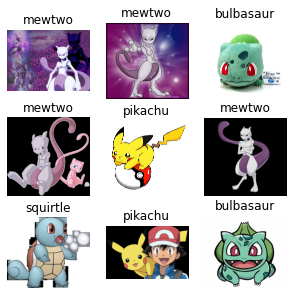

In [9]:
plt_mutli_images(images[:9])

In [10]:
def plt_single_image(image_path):
    image_data = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    title = image_path.split('/')[-2]
    plt.imshow(image_data)
    plt.title(title)
    plt.show()

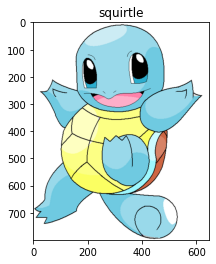

In [11]:
plt_single_image(images[9])

## 基于自定义数据集实战


### 数据预处理和创建Dataset对象

In [12]:
# 这里的mean和std根据真实的数据计算获得，比如ImageNet
img_mean = tf.constant([0.485, 0.456, 0.406])
img_std = tf.constant([0.229, 0.224, 0.225])
 
def normalize(x, mean=img_mean, std=img_std):
    # 标准化
    # x: [224, 224, 3]
    # mean: [224, 224, 3], std: [3]
    x = (x - mean)/std
    return x
 
def denormalize(x, mean=img_mean, std=img_std):
    # 标准化的逆过程
    x = x * std + mean
    return x

In [13]:
def preprocess(x,y):
    # x: 图片的路径List，y：图片的数字编码List
    x = tf.io.read_file(x) # 根据路径读取图片
    x = tf.image.decode_jpeg(x, channels=3) # 图片解码
    x = tf.image.resize(x, [244, 244]) # 图片缩放
 
    # 数据增强
    # x = tf.image.random_flip_up_down(x)
    x= tf.image.random_flip_left_right(x) # 左右镜像
    x = tf.image.random_crop(x, [224, 224, 3]) # 随机裁剪
    # 转换成张量
    # x: [0,255]=> 0~1
    x = tf.cast(x, dtype=tf.float32) / 255.
    # 0~1 => D(0,1)
    x = normalize(x) # 标准化
    y = tf.convert_to_tensor(y) # 转换成张量
 
    return x, y

### 展示数据预处理后内容

In [14]:
batchsz = 4
# 创建训练集 Dataset 对象
images, labels, table = load_pokemon(base_data_path, 'train')
db_train = tf.data.Dataset.from_tensor_slices((images, labels))
db_train = db_train.map(preprocess).batch(batchsz)

# 创建验证集 Dataset 对象
images2, labels2, table = load_pokemon(base_data_path,mode='val')
db_val = tf.data.Dataset.from_tensor_slices((images2, labels2))
db_val = db_val.map(preprocess).batch(batchsz)

# 创建测试集 Dataset 对象
images3, labels3, table = load_pokemon(base_data_path,mode='test')
db_test = tf.data.Dataset.from_tensor_slices((images3, labels3))
db_test = db_test.map(preprocess).batch(batchsz)

In [15]:
def plt_mutli_images_by_dataset(images_dataset, take_nums=1, figsize=5, images_num=4, row_images_num=2):
    for item, labels in images_dataset.take(take_nums):
        labels = labels.numpy()
        plt.figure(figsize=(figsize, figsize))
    for i in range(images_num):
        ax = plt.subplot(row_images_num, row_images_num, i + 1)
        # image_data = item[i].numpy().astype("uint8")
        image_data = item[i].numpy()
        plt.grid(False)
        plt.imshow(image_data)
        title = id2name_table[labels[i]]
        plt.title(title)
        plt.axis("off")
    plt.show()

In [16]:
# 类别数字编码映射为名称
id2name_table = {}
for item_key,item_val in table.items():
    id2name_table[item_val] = item_key
print(id2name_table)

{0: 'bulbasaur', 1: 'charmander', 2: 'mewtwo', 3: 'pikachu', 4: 'squirtle'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


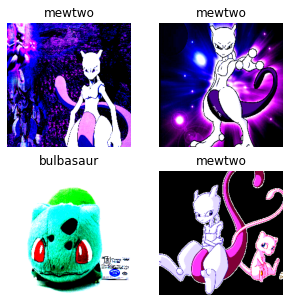

In [17]:
plt_mutli_images_by_dataset(db_train)

## 迁移学习

我们在 DenseNet121 的基础上，使用在 ImageNet 数据集上预训练好的模型参数初始化
DenseNet121 网络，并去除最后一个全连接层，追加新的分类子网络，最后一层的输出节
点数设置为 5。

### 模型搭建

In [24]:
model_path = "./pokenmon_lecture3.h5"

if os.path.exists(model_path):
    newnet = keras.models.load_model(model_path)
else:
    # todo
    # 迁移学习
    # 加载 DenseNet 网络模型，并去掉最后一层全连接层，最后一个池化层设置为 max pooling
    # 并使用预训练的参数初始化
    

In [ ]:
# 装配模型
newnet.compile(optimizer=optimizers.Adam(lr=1e-3), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# 创建 Early Stopping 类，连续 3 次不上升则终止训练
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3)


# 训练模型，支持 early stopping
history = newnet.fit(db_train, validation_data=db_val, validation_freq=1, epochs=100, callbacks=[early_stopping])

### 模型评估

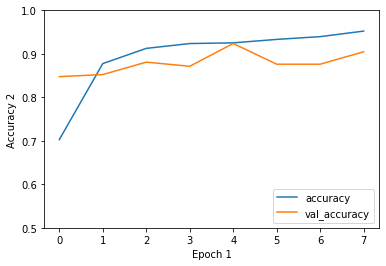

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch 1')
plt.ylabel('Accuracy 2')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

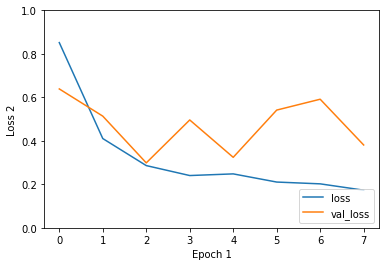

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch 1')
plt.ylabel('Loss 2')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

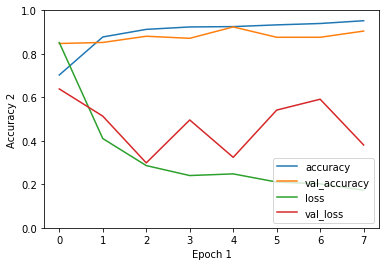

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch 1')
plt.ylabel('Accuracy 2')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [23]:
newnet.save(model_path)